In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:


!mkdir /kaggle/working/Grape
!mkdir /kaggle/working/Grape/test
!mkdir /kaggle/working/Grape/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Grape* /kaggle/working/Grape/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Grape* /kaggle/working/Grape/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(156),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Grape/train'
test_path='/kaggle/working/Grape/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*78*78, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [4]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [5]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [6]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=20
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 407/407 [00:34<00:00, 11.69it/s]


Train Loss: 1.011 | Accuracy: 53.960


100%|██████████| 102/102 [00:07<00:00, 14.36it/s]


Test Loss: 0.789 | Accuracy: 65.012

Epoch : 2


100%|██████████| 407/407 [00:28<00:00, 14.53it/s]


Train Loss: 0.752 | Accuracy: 66.641


100%|██████████| 102/102 [00:07<00:00, 13.68it/s]


Test Loss: 0.659 | Accuracy: 71.794

Epoch : 3


100%|██████████| 407/407 [00:28<00:00, 14.22it/s]


Train Loss: 0.707 | Accuracy: 68.933


100%|██████████| 102/102 [00:06<00:00, 14.79it/s]


Test Loss: 0.859 | Accuracy: 59.988

Epoch : 4


100%|██████████| 407/407 [00:28<00:00, 14.11it/s]


Train Loss: 0.684 | Accuracy: 70.901


100%|██████████| 102/102 [00:06<00:00, 15.10it/s]


Test Loss: 0.598 | Accuracy: 74.938

Epoch : 5


100%|██████████| 407/407 [00:28<00:00, 14.16it/s]


Train Loss: 0.643 | Accuracy: 72.470


100%|██████████| 102/102 [00:07<00:00, 14.18it/s]


Test Loss: 0.564 | Accuracy: 77.096

Epoch : 6


100%|██████████| 407/407 [00:28<00:00, 14.27it/s]


Train Loss: 0.615 | Accuracy: 74.146


100%|██████████| 102/102 [00:07<00:00, 13.03it/s]


Test Loss: 0.640 | Accuracy: 74.014

Epoch : 7


100%|██████████| 407/407 [00:27<00:00, 14.71it/s]


Train Loss: 0.602 | Accuracy: 75.169


100%|██████████| 102/102 [00:07<00:00, 13.17it/s]


Test Loss: 0.587 | Accuracy: 74.199

Epoch : 8


100%|██████████| 407/407 [00:29<00:00, 14.01it/s]


Train Loss: 0.593 | Accuracy: 75.746


100%|██████████| 102/102 [00:06<00:00, 15.35it/s]


Test Loss: 0.595 | Accuracy: 74.753

Epoch : 9


100%|██████████| 407/407 [00:29<00:00, 14.00it/s]


Train Loss: 0.579 | Accuracy: 76.184


100%|██████████| 102/102 [00:07<00:00, 14.19it/s]


Test Loss: 0.619 | Accuracy: 74.044

Epoch : 10


100%|██████████| 407/407 [00:28<00:00, 14.36it/s]


Train Loss: 0.547 | Accuracy: 78.599


100%|██████████| 102/102 [00:06<00:00, 14.64it/s]


Test Loss: 0.685 | Accuracy: 72.626

Epoch : 11


100%|██████████| 407/407 [00:28<00:00, 14.35it/s]


Train Loss: 0.543 | Accuracy: 78.137


100%|██████████| 102/102 [00:06<00:00, 14.74it/s]


Test Loss: 0.489 | Accuracy: 80.580

Epoch : 12


100%|██████████| 407/407 [00:28<00:00, 14.09it/s]


Train Loss: 0.530 | Accuracy: 78.930


100%|██████████| 102/102 [00:06<00:00, 14.69it/s]


Test Loss: 0.464 | Accuracy: 81.011

Epoch : 13


100%|██████████| 407/407 [00:28<00:00, 14.18it/s]


Train Loss: 0.522 | Accuracy: 79.691


100%|██████████| 102/102 [00:07<00:00, 14.18it/s]


Test Loss: 0.793 | Accuracy: 70.623

Epoch : 14


100%|██████████| 407/407 [00:28<00:00, 14.39it/s]


Train Loss: 0.510 | Accuracy: 79.998


100%|██████████| 102/102 [00:07<00:00, 14.26it/s]


Test Loss: 0.556 | Accuracy: 77.158

Epoch : 15


100%|██████████| 407/407 [00:28<00:00, 14.09it/s]


Train Loss: 0.490 | Accuracy: 81.121


100%|██████████| 102/102 [00:06<00:00, 15.01it/s]


Test Loss: 0.621 | Accuracy: 74.075

Epoch : 16


100%|██████████| 407/407 [00:28<00:00, 14.12it/s]


Train Loss: 0.497 | Accuracy: 81.021


100%|██████████| 102/102 [00:06<00:00, 14.99it/s]


Test Loss: 0.493 | Accuracy: 79.932

Epoch : 17


100%|██████████| 407/407 [00:28<00:00, 14.04it/s]


Train Loss: 0.477 | Accuracy: 81.744


100%|██████████| 102/102 [00:07<00:00, 12.94it/s]


Test Loss: 0.568 | Accuracy: 77.004

Epoch : 18


100%|██████████| 407/407 [00:27<00:00, 14.82it/s]


Train Loss: 0.475 | Accuracy: 81.929


100%|██████████| 102/102 [00:07<00:00, 12.88it/s]


Test Loss: 0.450 | Accuracy: 82.244

Epoch : 19


100%|██████████| 407/407 [00:27<00:00, 14.71it/s]


Train Loss: 0.469 | Accuracy: 82.029


100%|██████████| 102/102 [00:07<00:00, 12.91it/s]


Test Loss: 0.419 | Accuracy: 84.679

Epoch : 20


100%|██████████| 407/407 [00:28<00:00, 14.33it/s]


Train Loss: 0.459 | Accuracy: 82.751


100%|██████████| 102/102 [00:06<00:00, 15.04it/s]

Test Loss: 0.409 | Accuracy: 84.988


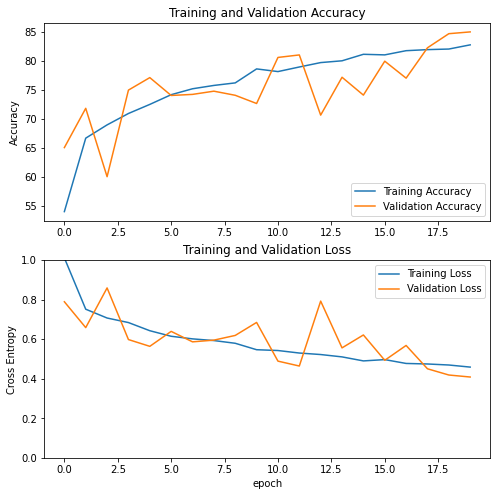

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()